In [45]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')
pd.options.display.max_columns = 300
sns.set_style('darkgrid')

In [46]:
#connect SQL
conn = psycopg2.connect(database='usaspending', user='team', password='ZAQ!@#zaq123', host='127.0.0.1', port='5432')

In [47]:
sql_cols = ('federal_action_obligation, '
            #'total_dollars_obligated, '
            'base_and_exercised_options_value, '
            'base_and_all_options_value, '
            'awarding_sub_agency_name, '
            'awarding_office_name, '
            #'funding_sub_agency_name, '
            #'funding_office_name, '
            #'primary_place_of_performance_state_code, '
            #'award_or_idv_flag, '
            #'award_type, '
            #'type_of_contract_pricing, '
            #'dod_claimant_program_description, '
            'type_of_set_aside_code, '
            #'multi_year_contract, '
            #'dod_acquisition_program_description, '
            #'subcontracting_plan, ' 
            #'contract_bundling, '
            #'evaluated_preference, ' 
            #'national_interest_action, '
            #'cost_or_pricing_data, ' 
            #'gfe_gfp, '
            #'contract_financing, '
            'portfolio_group, '
            #'product_or_service_code_description, '
            'naics_bucket_title'
            #'naics_description'
            )

In [48]:
#Create DF
sql_tbl_name = 'consolidated_data2'

df = pd.read_sql_query('SELECT ' + sql_cols + ' FROM ' + sql_tbl_name, con=conn)

In [49]:
df.head()

,federal_action_obligation,base_and_exercised_options_value,base_and_all_options_value,awarding_sub_agency_name,awarding_office_name,type_of_set_aside_code,portfolio_group,naics_bucket_title
0,10000.00,10000.00,10000.00,DEPT OF THE ARMY,W0MC USA DEP RED RIVER,NONE,Facility Related Services,Fabricated Metal Product ManufacturingT
1,998435.39,998435.39,1068200.54,DEPT OF THE ARMY,W07V ENDIST ROCK ISLAND,8AN,Facility Related Services,ConstructionT
2,124345.90,124345.90,124345.90,DEPT OF THE ARMY,W7NU USPFO ACTIVITY OH ARNG,SBA,Construction Services,ConstructionT
3,0.00,129999.40,129999.40,DEPT OF THE ARMY,W40M USA MEDCOM HCAA,SBA,Facility Related Services,Real Estate and Rental and LeasingT
4,200.00,200.00,200.00,DEPT OF THE ARMY,W7NR USPFO ACTIVITY NY ARNG,SBA,Construction Services,ConstructionT


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272790 entries, 0 to 272789
Data columns (total 8 columns):
federal_action_obligation           272790 non-null float64
base_and_exercised_options_value    272790 non-null float64
base_and_all_options_value          272790 non-null float64
awarding_sub_agency_name            272790 non-null object
awarding_office_name                272790 non-null object
type_of_set_aside_code              270987 non-null object
portfolio_group                     272790 non-null object
naics_bucket_title                  242418 non-null object
dtypes: float64(3), object(5)
memory usage: 16.6+ MB


In [51]:
df.isnull().sum()

federal_action_obligation               0
base_and_exercised_options_value        0
base_and_all_options_value              0
awarding_sub_agency_name                0
awarding_office_name                    0
type_of_set_aside_code               1803
portfolio_group                         0
naics_bucket_title                  30372
dtype: int64

In [52]:
df = df.dropna()
df.shape

(240832, 8)

In [53]:
def set_aside(c):
    if c['type_of_set_aside_code'] == 'NONE':
        return 0
    else:
        return 1

In [54]:
#Create column name 'set_aside' and apply function to populate rows with 0 or 1.
df['set_aside'] = df.apply(set_aside, axis=1)

In [55]:
def contract_value(c):
    if c['base_and_exercised_options_value'] > 0:
        return c['base_and_exercised_options_value']
    elif c['base_and_all_options_value'] > 0:
        return c['base_and_all_options_value']
    elif c['federal_action_obligation'] > 0:
        return c['federal_action_obligation'] 
    else:
        return 0

In [56]:
df['contract_value'] = df.apply(contract_value, axis=1)

In [57]:
#Drop columns that we dont need anymore.
df = df.drop(['type_of_set_aside_code','base_and_exercised_options_value','base_and_all_options_value',
             'federal_action_obligation'], axis=1)

In [58]:
df.isnull().sum()

awarding_sub_agency_name    0
awarding_office_name        0
portfolio_group             0
naics_bucket_title          0
set_aside                   0
contract_value              0
dtype: int64

In [59]:
#Create features DF
X = df.drop(['set_aside'], axis=1).copy()

In [60]:
X.head()

,awarding_sub_agency_name,awarding_office_name,portfolio_group,naics_bucket_title,contract_value
0,DEPT OF THE ARMY,W0MC USA DEP RED RIVER,Facility Related Services,Fabricated Metal Product ManufacturingT,10000.00
1,DEPT OF THE ARMY,W07V ENDIST ROCK ISLAND,Facility Related Services,ConstructionT,998435.39
2,DEPT OF THE ARMY,W7NU USPFO ACTIVITY OH ARNG,Construction Services,ConstructionT,124345.90
3,DEPT OF THE ARMY,W40M USA MEDCOM HCAA,Facility Related Services,Real Estate and Rental and LeasingT,129999.40
4,DEPT OF THE ARMY,W7NR USPFO ACTIVITY NY ARNG,Construction Services,ConstructionT,200.00


In [61]:
#Create Target
y = df['set_aside']

In [62]:
y.value_counts()

0    125554
1    115278
Name: set_aside, dtype: int64

In [63]:
#Convert all the Features Char to Binary
X = pd.get_dummies(X)

In [64]:
X.head()

,contract_value,awarding_sub_agency_name_DEFENSE ADVANCED RESEARCH PROJECTS AGENCY (DARPA),awarding_sub_agency_name_DEFENSE COMMISSARY AGENCY (DECA),awarding_sub_agency_name_DEFENSE CONTRACT MANAGEMENT AGENCY (DCMA),awarding_sub_agency_name_DEFENSE COUNTERINTELLIGENCE AND SECURITY AGENCY,awarding_sub_agency_name_DEFENSE FINANCE AND ACCOUNTING SERVICE (DFAS),awarding_sub_agency_name_DEFENSE HEALTH AGENCY (DHA),awarding_sub_agency_name_DEFENSE HUMAN RESOURCES ACTIVITY,awarding_sub_agency_name_DEFENSE INFORMATION SYSTEMS AGENCY (DISA),awarding_sub_agency_name_DEFENSE LOGISTICS AGENCY,awarding_sub_agency_name_DEFENSE MEDIA ACTIVITY (DMA),awarding_sub_agency_name_DEFENSE MICROELECTRONICS ACTIVITY (DMEA),awarding_sub_agency_name_DEFENSE SECURITY COOPERATION AGENCY,awarding_sub_agency_name_DEFENSE THREAT REDUCTION AGENCY (DTRA),awarding_sub_agency_name_DEPT OF DEFENSE EDUCATION ACTIVITY (DODEA),awarding_sub_agency_name_DEPT OF THE AIR FORCE,awarding_sub_agency_name_DEPT OF THE ARMY,awarding_sub_agency_name_DEPT OF THE NAVY,awarding_sub_agency_name_JOINT IMPROVISED EXPLOSIVE DEVICE DEFEAT ORGANIZATION (JIEDDO),awarding_sub_agency_name_JOINT IMPROVISED EXPLOSIVE DEVICE DEFEAT ORGANIZATION (JIEDDO),awarding_sub_agency_name_MISSILE DEFENSE AGENCY (MDA),awarding_sub_agency_name_U.S. SPECIAL OPERATIONS COMMAND (USSOCOM),awarding_sub_agency_name_UNIFORMED SERVICES UNIVERSITY OF THE HEALTH SCIENCES (USUHS),awarding_sub_agency_name_USTRANSCOM,awarding_sub_agency_name_WASHINGTON HEADQUARTERS SERVICES (WHS),awarding_office_name_0409 AQ HQ,awarding_office_name_0409 AQ HQ CONTRACT,awarding_office_name_0410 AQ HQ,awarding_office_name_0410 AQ HQ CONTRACT,awarding_office_name_0411 AQ HQ CONTRACT AUG,awarding_office_name_0411 AQ HQ HQ PARC,awarding_office_name_0413 AQ HQ,awarding_office_name_0413 AQ HQ CONTRACT,awarding_office_name_0413 AQ HQ HQ PARC,awarding_office_name_0414 AQ HQ HQ PARC,awarding_office_name_0629 AQ TM CONTRACTING TEA,awarding_office_name_0670 AQ TM CONTRACTING TEA,awarding_office_name_646TH SUPPORT DETACHMENT,awarding_office_name_ACC-ABERDEEN PROVING GROUNDS CONT C,awarding_office_name_ACC-ABERDEEN PROVING GROUNDS CONTR,awarding_office_name_ACC-AVIATION APPLIED TECHNOLOGY DIR,awarding_office_name_BLUE GRASS ARMY DEPOT,awarding_office_name_CDR US PACIFIC COMMAND USPACOM,awarding_office_name_CENTER FOR INFORMATION DOMINANCE,awarding_office_name_CENTER FOR PERSONAL AND,awarding_office_name_COMMANDANT,awarding_office_name_COMMANDER,awarding_office_name_COMMANDER NAVAL SAFETY CENTER,"awarding_office_name_COMMANDER, MCINCR-MCBQ",awarding_office_name_COMMANDING GENERAL,awarding_office_name_COMMANDING GENERAL (M68450),awarding_office_name_COMMANDING OFFICER,awarding_office_name_COMMANDING OFFICER TMO,"awarding_office_name_COMMANDING OFFICER, MWTC",awarding_office_name_COMNAVAIRLANT,awarding_office_name_COMPTROLLER,awarding_office_name_CONTRACTING OPERATIONS DIVISION,awarding_office_name_CRYPTOLOGIC WARFARE GROUP SIX,awarding_office_name_DCMA AIMO - ST AUGUSTINE,awarding_office_name_DCMA AIMO KELLY SAN ANTONIO,awarding_office_name_DCMA AIMO ST AUGUSTINE,awarding_office_name_DCMA APO KELLY SAN ANTONIO,awarding_office_name_DCMA BOEING,awarding_office_name_DCMA RAYTHEON TUCSON,awarding_office_name_DCMA SANTA ANA,awarding_office_name_DCSO COLUMBUS,awarding_office_name_DCSO ENERGY,awarding_office_name_DCSO FORT BELVOIR,awarding_office_name_DCSO NEW CUMBERLAND,awarding_office_name_DCSO PHILADELPHIA,awarding_office_name_DCSO RICHMOND,awarding_office_name_DCSO-NEW CUMBERLAND,awarding_office_name_DCSO-P NEW CUMBERLAND,awarding_office_name_DCSO-P/HARRISBURG,awarding_office_name_DDESS AREA SERVICE CENTER,awarding_office_name_DEF ADVANCED RESEARCH PROJECTS AGCY,awarding_office_name_DEFENSE ACTIVITY FOR,awarding_office_name_DEFENSE CI AND SECURITY AGENCY,awarding_office_name_DEFENSE COMMISSARY AGENCY,awarding_office_name_DEFENSE CONTRACT MANAGEMENT AGENCY,awarding_office_name_DEFENSE CONTRACT MANAGMENT OFFICE,awarding_office_name_DEFENSE FINANCE AND AC

In [65]:
from sklearn.model_selection import train_test_split, cross_val_score
from yellowbrick.classifier import ClassificationReport
from sklearn.ensemble import RandomForestClassifier

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [93]:
model = RandomForestClassifier(n_estimators=17)

In [94]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=17,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [95]:
predictions = model.predict(X_test)

In [96]:
classes = ['None', 'Set Aside']

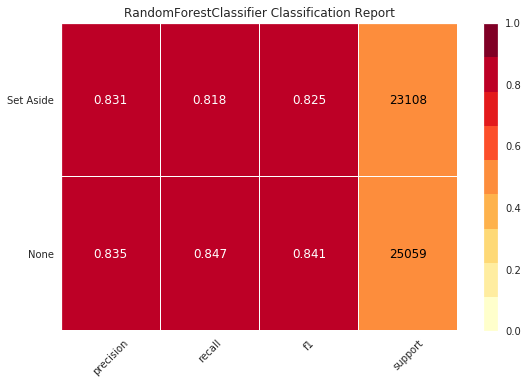

In [97]:
visualizer = ClassificationReport(model, classes=classes, support=True)
visualizer.score(X_test, y_test)
visualizer.show()

In [33]:
#test model with single input
a = X.iloc[2:3,:]

In [34]:
a

,awarding_sub_agency_name_DEFENSE ADVANCED RESEARCH PROJECTS AGENCY (DARPA),awarding_sub_agency_name_DEFENSE COMMISSARY AGENCY (DECA),awarding_sub_agency_name_DEFENSE CONTRACT MANAGEMENT AGENCY (DCMA),awarding_sub_agency_name_DEFENSE COUNTERINTELLIGENCE AND SECURITY AGENCY,awarding_sub_agency_name_DEFENSE FINANCE AND ACCOUNTING SERVICE (DFAS),awarding_sub_agency_name_DEFENSE HEALTH AGENCY (DHA),awarding_sub_agency_name_DEFENSE HUMAN RESOURCES ACTIVITY,awarding_sub_agency_name_DEFENSE INFORMATION SYSTEMS AGENCY (DISA),awarding_sub_agency_name_DEFENSE LOGISTICS AGENCY,awarding_sub_agency_name_DEFENSE MEDIA ACTIVITY (DMA),awarding_sub_agency_name_DEFENSE MICROELECTRONICS ACTIVITY (DMEA),awarding_sub_agency_name_DEFENSE SECURITY COOPERATION AGENCY,awarding_sub_agency_name_DEFENSE THREAT REDUCTION AGENCY (DTRA),awarding_sub_agency_name_DEPT OF DEFENSE EDUCATION ACTIVITY (DODEA),awarding_sub_agency_name_DEPT OF THE AIR FORCE,awarding_sub_agency_name_DEPT OF THE ARMY,awarding_sub_agency_name_DEPT OF THE NAVY,awarding_sub_agency_name_JOINT IMPROVISED EXPLOSIVE DEVICE DEFEAT ORGANIZATION (JIEDDO),awarding_sub_agency_name_JOINT IMPROVISED EXPLOSIVE DEVICE DEFEAT ORGANIZATION (JIEDDO),awarding_sub_agency_name_MISSILE DEFENSE AGENCY (MDA),awarding_sub_agency_name_U.S. SPECIAL OPERATIONS COMMAND (USSOCOM),awarding_sub_agency_name_UNIFORMED SERVICES UNIVERSITY OF THE HEALTH SCIENCES (USUHS),awarding_sub_agency_name_USTRANSCOM,awarding_sub_agency_name_WASHINGTON HEADQUARTERS SERVICES (WHS),awarding_office_name_0409 AQ HQ,awarding_office_name_0409 AQ HQ CONTRACT,awarding_office_name_0410 AQ HQ,awarding_office_name_0410 AQ HQ CONTRACT,awarding_office_name_0411 AQ HQ CONTRACT AUG,awarding_office_name_0411 AQ HQ HQ PARC,awarding_office_name_0413 AQ HQ,awarding_office_name_0413 AQ HQ CONTRACT,awarding_office_name_0413 AQ HQ HQ PARC,awarding_office_name_0414 AQ HQ HQ PARC,awarding_office_name_0629 AQ TM CONTRACTING TEA,awarding_office_name_0670 AQ TM CONTRACTING TEA,awarding_office_name_646TH SUPPORT DETACHMENT,awarding_office_name_ACC-ABERDEEN PROVING GROUNDS CONT C,awarding_office_name_ACC-ABERDEEN PROVING GROUNDS CONTR,awarding_office_name_ACC-AVIATION APPLIED TECHNOLOGY DIR,awarding_office_name_BLUE GRASS ARMY DEPOT,awarding_office_name_CDR US PACIFIC COMMAND USPACOM,awarding_office_name_CENTER FOR INFORMATION DOMINANCE,awarding_office_name_CENTER FOR PERSONAL AND,awarding_office_name_COMMANDANT,awarding_office_name_COMMANDER,awarding_office_name_COMMANDER NAVAL SAFETY CENTER,"awarding_office_name_COMMANDER, MCINCR-MCBQ",awarding_office_name_COMMANDING GENERAL,awarding_office_name_COMMANDING GENERAL (M68450),awarding_office_name_COMMANDING OFFICER,awarding_office_name_COMMANDING OFFICER TMO,"awarding_office_name_COMMANDING OFFICER, MWTC",awarding_office_name_COMNAVAIRLANT,awarding_office_name_COMPTROLLER,awarding_office_name_CONTRACTING OPERATIONS DIVISION,awarding_office_name_CRYPTOLOGIC WARFARE GROUP SIX,awarding_office_name_DCMA AIMO - ST AUGUSTINE,awarding_office_name_DCMA AIMO KELLY SAN ANTONIO,awarding_office_name_DCMA AIMO ST AUGUSTINE,awarding_office_name_DCMA APO KELLY SAN ANTONIO,awarding_office_name_DCMA BOEING,awarding_office_name_DCMA RAYTHEON TUCSON,awarding_office_name_DCMA SANTA ANA,awarding_office_name_DCSO COLUMBUS,awarding_office_name_DCSO ENERGY,awarding_office_name_DCSO FORT BELVOIR,awarding_office_name_DCSO NEW CUMBERLAND,awarding_office_name_DCSO PHILADELPHIA,awarding_office_name_DCSO RICHMOND,awarding_office_name_DCSO-NEW CUMBERLAND,awarding_office_name_DCSO-P NEW CUMBERLAND,awarding_office_name_DCSO-P/HARRISBURG,awarding_office_name_DDESS AREA SERVICE CENTER,awarding_office_name_DEF ADVANCED RESEARCH PROJECTS AGCY,awarding_office_name_DEFENSE ACTIVITY FOR,awarding_office_name_DEFENSE CI AND SECURITY AGENCY,awarding_office_name_DEFENSE COMMISSARY AGENCY,awarding_office_name_DEFENSE CONTRACT MANAGEMENT AGENCY,awarding_office_name_DEFENSE CONTRACT MANAGMENT OFFICE,awarding_office_name_DEFENSE FINANCE AND ACCOUNTING SVC,aw

In [35]:
predictions1 =  model.predict(a)

In [36]:
print(predictions1)

[1]


## Second Model for Set Aside 

In [37]:
df1 = pd.read_sql_query('SELECT ' + sql_cols + ' FROM ' + sql_tbl_name, con=conn)

In [38]:
none_set_asides = df1[df1['type_of_set_aside_code']== 'NONE'].index
df1.shape

(272790, 11)

In [39]:
df1.head(20)

,federal_action_obligation,base_and_exercised_options_value,base_and_all_options_value,awarding_sub_agency_name,awarding_office_name,funding_sub_agency_name,funding_office_name,primary_place_of_performance_state_code,type_of_set_aside_code,portfolio_group,naics_bucket_title
0,10000.00,10000.00,10000.00,DEPT OF THE ARMY,W0MC USA DEP RED RIVER,DEPT OF THE ARMY,W0MC STK REC ACCT DEPOT REDRVR,TX,NONE,Facility Related Services,Fabricated Metal Product ManufacturingT
1,998435.39,998435.39,1068200.54,DEPT OF THE ARMY,W07V ENDIST ROCK ISLAND,DEPT OF THE ARMY,W07V ENDIST ROCK ISLAND,MI,8AN,Facility Related Services,ConstructionT
2,124345.90,124345.90,124345.90,DEPT OF THE ARMY,W7NU USPFO ACTIVITY OH ARNG,DEPT OF THE AIR FORCE,FA6352 178 FW LGC BECKLEY MAP,OH,SBA,Construction Services,ConstructionT
3,0.00,129999.40,129999.40,DEPT OF THE ARMY,W40M USA MEDCOM HCAA,DEPT OF THE ARMY,W2L8 USA MEDDAC FT CAMPBELL,MI,SBA,Facility Related Services,Real Estate and Rental and LeasingT
4,200.00,200.00,200.00,DEPT OF THE ARMY,W7NR USPFO ACTIVITY NY ARNG,DEPT OF THE AIR FORCE,FA6323 109 MSG MSC STRATTON ANGB,NY,SBA,Construction Services,ConstructionT
5,76797.50,76797.50,76797.50,DEPT OF THE NAVY,NAVFAC SOUTHWEST,DEPT OF THE NAVY,NAVFAC SOUTHWEST,CA,NONE,Facility Related Services,Administrative and Support and Waste Managemen...
6,182323.20,182323.20,182323.20,DEPT OF THE ARMY,US ARMY ENGINEER DISTRICT SAVANNAH,U.S. ARMY CORPS OF ENGINEERS - CIVIL PROGRAM F...,SAVANNAH,GA,8AN,Knowledge Based Services,"Professional, Scientific, and Technical ServicesT"
7,315055.80,315055.80,1659566.98,DEPT OF THE ARMY,W6QM MICC-FDO FT SAM HOUSTON,DEPT OF THE ARMY,INSTALLATION MANAGEMENT COMMAND,NC,SBA,Facility Related Services,"Professional, Scientific, and Technical ServicesT"
8,151943.84,151943.84,151943.84,DEPT OF THE ARMY,W2R2 USA ENGR R AND D CTR,U.S. ARMY CORPS OF ENGINEERS - CIVIL PROGRAM F...,PR W2R2 USA ENGR R AND D CTR,VA,NONE,Knowledge Based Services,"Professional, Scientific, and Technical ServicesT"
9,553224.00,553224.00,553224.00,DEPT OF THE AIR FORCE,FA4861 99 CONS LGC,DEPT OF THE AIR FORCE,99 CES PROJECTS,NV,8A,Construction Services,ConstructionT


In [40]:
#drop all the set_aside = NONE
df1 = df1.drop(none_set_asides, axis=0)

In [41]:
def contract_value(c):
    if c['base_and_exercised_options_value'] > 0:
        return c['base_and_exercised_options_value']
    elif c['base_and_all_options_value'] > 0:
        return c['base_and_all_options_value']
    elif c['federal_action_obligation'] > 0:
        return c['federal_action_obligation'] 
    else:
        return 0

In [42]:
df1['contract_value'] = df1.apply(contract_value, axis=1)

In [43]:
df1['set_aside_number'] = df1['type_of_set_aside_code'].map({'SBA':1, 'WOSB':2, '8A':3, '8AN':4, 'SDVOSBC':5,'HZC':6,'SBP':7, 'SDVOSBS':8, 'EDWOSB':9, 'WOSBSS':10, 'HZS':11, 'ISBEE':11})

In [44]:
#Drop columns that we dont need anymore.
df1 = df1.drop(['type_of_set_aside_code','base_and_exercised_options_value','base_and_all_options_value',
             'federal_action_obligation'], axis=1)

In [45]:
df1 = df1.dropna()
df1.shape

(114163, 9)

In [46]:
X1 = df1.drop(['set_aside_number'], axis=1)

In [47]:
X1 = pd.get_dummies(X1)

In [48]:
y1 = df1['set_aside_number']

In [49]:
y1.head()

1    4.0
2    1.0
3    1.0
4    1.0
6    4.0
Name: set_aside_number, dtype: float64

In [50]:
y1.value_counts()

1.0     68768
4.0     19354
3.0     14820
5.0      4115
6.0      3733
2.0      1993
7.0       734
9.0       346
8.0       167
11.0       75
10.0       58
Name: set_aside_number, dtype: int64

In [51]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=42)

In [52]:
model1 = RandomForestClassifier(n_estimators=17)

In [53]:
model1.fit(X1_train, y1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=17,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [54]:
classes1 = ['SBA', 'WOSB', '8A', '8AN', 'SDVOSBC','HZC', 'SBP', 'SDVOSBS', 'EDWOSB', 'WOSBSS', 'HZS']

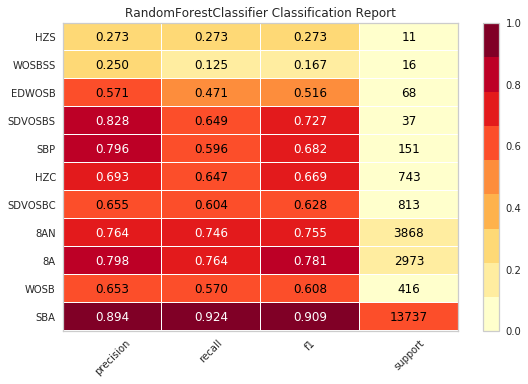

In [55]:
for pred in predictions1:
    if pred == 1:
        visualizer = ClassificationReport(model1, classes=classes1, support=True)
        visualizer.score(X1_test, y1_test)
        visualizer.show()
    else :
        print('Not Set Aside')

In [56]:
#Test single row
b = X1.iloc[:1,:]

In [57]:
b

,contract_value,awarding_sub_agency_name_DEFENSE ADVANCED RESEARCH PROJECTS AGENCY (DARPA),awarding_sub_agency_name_DEFENSE COMMISSARY AGENCY (DECA),awarding_sub_agency_name_DEFENSE CONTRACT MANAGEMENT AGENCY (DCMA),awarding_sub_agency_name_DEFENSE COUNTERINTELLIGENCE AND SECURITY AGENCY,awarding_sub_agency_name_DEFENSE FINANCE AND ACCOUNTING SERVICE (DFAS),awarding_sub_agency_name_DEFENSE HEALTH AGENCY (DHA),awarding_sub_agency_name_DEFENSE HUMAN RESOURCES ACTIVITY,awarding_sub_agency_name_DEFENSE INFORMATION SYSTEMS AGENCY (DISA),awarding_sub_agency_name_DEFENSE LOGISTICS AGENCY,awarding_sub_agency_name_DEFENSE MEDIA ACTIVITY (DMA),awarding_sub_agency_name_DEFENSE MICROELECTRONICS ACTIVITY (DMEA),awarding_sub_agency_name_DEFENSE SECURITY COOPERATION AGENCY,awarding_sub_agency_name_DEFENSE THREAT REDUCTION AGENCY (DTRA),awarding_sub_agency_name_DEPT OF DEFENSE EDUCATION ACTIVITY (DODEA),awarding_sub_agency_name_DEPT OF THE AIR FORCE,awarding_sub_agency_name_DEPT OF THE ARMY,awarding_sub_agency_name_DEPT OF THE NAVY,awarding_sub_agency_name_JOINT IMPROVISED EXPLOSIVE DEVICE DEFEAT ORGANIZATION (JIEDDO),awarding_sub_agency_name_JOINT IMPROVISED EXPLOSIVE DEVICE DEFEAT ORGANIZATION (JIEDDO),awarding_sub_agency_name_MISSILE DEFENSE AGENCY (MDA),awarding_sub_agency_name_U.S. SPECIAL OPERATIONS COMMAND (USSOCOM),awarding_sub_agency_name_UNIFORMED SERVICES UNIVERSITY OF THE HEALTH SCIENCES (USUHS),awarding_sub_agency_name_USTRANSCOM,awarding_sub_agency_name_WASHINGTON HEADQUARTERS SERVICES (WHS),awarding_office_name_0410 AQ HQ,awarding_office_name_0410 AQ HQ CONTRACT,awarding_office_name_0413 AQ HQ,awarding_office_name_0413 AQ HQ CONTRACT,awarding_office_name_0413 AQ HQ HQ PARC,awarding_office_name_ACC-ABERDEEN PROVING GROUNDS CONT C,awarding_office_name_ACC-ABERDEEN PROVING GROUNDS CONTR,awarding_office_name_ACC-AVIATION APPLIED TECHNOLOGY DIR,awarding_office_name_BLUE GRASS ARMY DEPOT,awarding_office_name_COMMANDANT,awarding_office_name_COMMANDER,awarding_office_name_COMMANDER NAVAL SAFETY CENTER,"awarding_office_name_COMMANDER, MCINCR-MCBQ",awarding_office_name_COMMANDING GENERAL,awarding_office_name_COMMANDING GENERAL (M68450),awarding_office_name_COMMANDING OFFICER,awarding_office_name_COMMANDING OFFICER TMO,"awarding_office_name_COMMANDING OFFICER, MWTC",awarding_office_name_COMPTROLLER,awarding_office_name_CONTRACTING OPERATIONS DIVISION,awarding_office_name_CRYPTOLOGIC WARFARE GROUP SIX,awarding_office_name_DCSO COLUMBUS,awarding_office_name_DCSO ENERGY,awarding_office_name_DCSO FORT BELVOIR,awarding_office_name_DCSO NEW CUMBERLAND,awarding_office_name_DCSO PHILADELPHIA,awarding_office_name_DCSO RICHMOND,awarding_office_name_DCSO-NEW CUMBERLAND,awarding_office_name_DCSO-P NEW CUMBERLAND,awarding_office_name_DCSO-P/HARRISBURG,awarding_office_name_DDESS AREA SERVICE CENTER,awarding_office_name_DEF ADVANCED RESEARCH PROJECTS AGCY,awarding_office_name_DEFENSE ACTIVITY FOR,awarding_office_name_DEFENSE CI AND SECURITY AGENCY,awarding_office_name_DEFENSE COMMISSARY AGENCY,awarding_office_name_DEFENSE CONTRACT MANAGEMENT AGENCY,awarding_office_name_DEFENSE CONTRACT MANAGMENT OFFICE,awarding_office_name_DEFENSE FINANCE AND ACCOUNTING SVC,awarding_office_name_DEFENSE HEALTH AGENCY,awarding_office_name_DEFENSE HEALTH AGENCY - AURORA,awarding_office_name_DEFENSE HEALTH AGENCY - FALLS CHURCH,awarding_office_name_DEFENSE HUMAN RESOURCES ACTIVITY,awarding_office_name_DEFENSE INFORMATION SYSTEMS AGENCY,awarding_office_name_DEFENSE INFORMATION SYSTEMS ANGENCY,awarding_office_name_DEFENSE MICROELECTRONICS ACTIVITY,awarding_office_name_DEFENSE SECURITY COOPERATION AGENCY,awarding_office_name_DEFENSE THREAT REDUCTION AGENCY,awarding_office_name_DES DSCP CONTRACTING SERVICES OFC,awarding_office_name_DITCO-PAC,awarding_office_name_DITCO-SCOTT,awarding_office_name_DLA DOCUMENT SERVICES,awarding_office_name_DLA ENERGY,awarding_office_name_DLA AVIATION,"awarding_office_name_DLA AVIATION AT PHILADELPHIA, PA","awarding_office_name_DLA AVIATION AT WARN

In [58]:
set_aside_name = model1.predict(b)

In [59]:
for j in set_aside_name:
    if j == 1:
        print('SBA')
    elif j == 2:
        print('WOSB')
    elif j == 3:
        print('8A')
    elif j == 4:
        print('8AN')
    elif j == 5:
        print('SDVOSBC')
    elif j == 6:
        print('HZC')
    elif j == 7:
        print('SBP')
    elif j == 8:
        print('SDVOSBS')
    elif j == 9:
        print('EDWOSB')
    elif j == 10:
        print('WOSBSS')
    elif j == 11:
        print('HZS')
    else:
        'ISBEE'

8AN
